# TODO:
### - <s>*Program the VWAP Indicator*</s>
### - <s>*Program the Supertrend Indicator*</s>
### - <s>*Plot and Test if values fit with Tradingview*</s>
### - <s>*Plot the indicators*</s>
### - <s>*Structurize the Strategy for instant usage*</s>
### - <s>*Heikin Ashi Transformer*</s>
### - *Finish the SMC Indicator*
### - *Then Finish the Strategy*
### - *If the Strategy works like wanted:*
- Use some API to retrieve Data
- Structure the code (all in ipynb for testing rn)
- Test the Algo with Machine Learning
### Done
---

## Imports
---

In [290]:
import pandas as pd 
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

from heikin_ashi import heikin_ashi

## Getting the Data
---

In [291]:
data = pd.read_csv("./BTCUSDT-3m-2023-04-30.csv")
data['Opent'] = pd.to_datetime(data['Opent'], unit='ms')
data['Opent'] = data['Opent'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
data.set_index('Opent', inplace=True)

In [292]:
data2 = pd.read_csv("./BTCUSDT-3m-2023-05-04.csv")
data2['Opent'] = pd.to_datetime(data2['Opent'], unit='ms')
data2['Opent'] = pd.to_datetime(data2['Opent'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')))
data2.set_index('Opent', inplace=True)

## Polygon API
---

In [366]:
#import modules
from polygon import RESTClient
import datetime as dt

polygonAPIkey = 'n5WUioGpm5YNuvJ0Bfn_No8nQHdfn_eP'
client = RESTClient(api_key=polygonAPIkey)

def getData(ticker, timespan, start, end):
    bars = client.get_aggs(ticker=ticker, multiplier=1, timespan=timespan, from_=start, to=end)
    print(len(bars))


    #list of polygon OptionsContract objects to DataFrame
    downloadedData = pd.DataFrame(bars)

    #create Date column
    downloadedData['Date'] = downloadedData['timestamp'].apply(
                            lambda x: pd.to_datetime(x*1000000))

    downloadedData = downloadedData.set_index('Date')

    #drop unnecessary columns
    downloadedData = downloadedData.drop(['vwap', 'transactions', 'otc'], axis=1)
    downloadedData = downloadedData.rename(columns={"open": "Open", "high": "High", "low": "Low", "close": "Close", "volume": "Volume"})

    return downloadedData

data3 = getData("C:EURUSD", "minute", "2023-05-01", "2023-05-08")
data3.iloc[0:30]

5000


,Open,High,Low,Close,Volume,timestamp
Date,,,,,,
2023-05-01 00:00:00,1.10106,1.10107,1.10090,1.10106,13,1682899200000
2023-05-01 00:02:00,1.10117,1.10130,1.10100,1.10126,65,1682899320000
2023-05-01 00:03:00,1.10127,1.10130,1.10110,1.10122,83,1682899380000
2023-05-01 00:04:00,1.10123,1.10140,1.10110,1.10137,44,1682899440000
2023-05-01 00:05:00,1.10135,1.10142,1.10120,1.10137,71,1682899500000
2023-05-01 00:06:00,1.10138,1.10150,1.10120,1.10120,48,1682899560000
2023-05-01 00:07:00,1.10133,1.10140,1.10110,1.10125,41,1682899620000
2023-05-01 00:08:00,1.10127,1.10130,1.10090,1.10110,53,1682899680000
2023-05-01 00:09:00,1.10107,1.10122,1.10090,1.10122,53,1682899740000


In [294]:
data2

,Open,High,Low,Close,Volume,Close time,Volume pair,TradeNr,useless,useless2,nothing
Opent,,,,,,,,,,,
2023-05-04 00:00:00,29026.16,29062.27,29020.00,29060.09,167.33470,1683158579999,4.859000e+06,3270,113.20887,3.287392e+06,0
2023-05-04 00:03:00,29060.10,29063.19,29046.02,29047.76,79.49311,1683158759999,2.309657e+06,1949,42.87514,1.245679e+06,0
2023-05-04 00:06:00,29047.75,29047.76,29003.37,29020.82,153.37783,1683158939999,4.450671e+06,2626,86.79922,2.518584e+06,0
2023-05-04 00:09:00,29020.82,29039.81,28990.90,29039.81,96.86582,1683159119999,2.810214e+06,2386,49.41884,1.433736e+06,0
2023-05-04 00:12:00,29039.80,29085.69,29039.80,29080.05,111.48081,1683159299999,3.241152e+06,2524,62.46409,1.815936e+06,0
...,...,...,...,...,...,...,...,...,...,...,...
2023-05-04 23:45:00,28811.58,28820.70,28808.19,28820.68,19.60646,1683244079999,5.649318e+05,719,11.51928,3.318844e+05,0
2023-05-04 23:48:00,28820.69,28836.22,28820.68,28836.22,29.54833,1683244259999,8.517463e+05,805,22.98839,6.626613e+05,0
2023-05-04 23:51:00,28836.21,28836.22,28830.64,28834.85,27.99093,1683244439999,8.070824e+05,800,9.84345,2.838206e+05,0


## VWAP
---

In [295]:
data

,Open,High,Low,Close,Volume,Close time,Volume pair,TradeNr,useless,useless2,nothing
Opent,,,,,,,,,,,
2023-04-30 00:00:00,29230.45,29230.49,29226.51,29226.51,27.31090,1682812979999,7.982928e+05,1092,7.00785,2.048399e+05,0
2023-04-30 00:03:00,29226.52,29226.52,29224.22,29224.23,20.29375,1682813159999,5.931144e+05,896,5.62308,1.643428e+05,0
2023-04-30 00:06:00,29224.22,29224.23,29210.53,29214.54,37.72225,1682813339999,1.102187e+06,1289,10.70671,3.128423e+05,0
2023-04-30 00:09:00,29214.54,29223.28,29213.01,29213.02,17.10613,1682813519999,4.997941e+05,1021,5.44545,1.591043e+05,0
2023-04-30 00:12:00,29213.02,29217.23,29213.01,29213.02,21.45128,1682813699999,6.266831e+05,971,13.73436,4.012334e+05,0
...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30 23:45:00,29392.33,29392.34,29343.27,29343.27,42.66521,1682898479999,1.253194e+06,1541,18.35114,5.390929e+05,0
2023-04-30 23:48:00,29343.27,29351.42,29293.84,29316.92,165.68337,1682898659999,4.857319e+06,4768,71.05387,2.082841e+06,0
2023-04-30 23:51:00,29316.92,29344.78,29306.53,29306.53,102.66224,1682898839999,3.010579e+06,2181,36.08370,1.058252e+06,0


In [296]:
def VWAP2(df: pd.DataFrame, band):
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['TradedValue'] = df['TP'] * df['Volume']
    df['CumulativeTradedValue'] = df['TradedValue'].cumsum()
    df['CumulativeVolume'] = df['Volume'].cumsum()
    df['VWAP'] = df['CumulativeTradedValue'] / df['CumulativeVolume']
    
    df['TypicalPriceDev'] = (df['Close'] - df['VWAP'])**2
    df['TPVDev'] = df['TypicalPriceDev'] * df['Volume']
    df['CumTPVDev'] = df['TPVDev'].cumsum()
    df['VWAPStdev'] = np.sqrt(df['CumTPVDev'] / df['CumulativeVolume'])


    # calculate upper and lower bands
    df['UpperBand1'] = df['VWAP'] + 1 * df['VWAPStdev']
    df['LowerBand1'] = df['VWAP'] - 1 * df['VWAPStdev']
    df['UpperBand2'] = df['VWAP'] + 2 * df['VWAPStdev']
    df['LowerBand2'] = df['VWAP'] - 2 * df['VWAPStdev']
    df['UpperBand3'] = df['VWAP'] + 3 * df['VWAPStdev']
    df['LowerBand3'] = df['VWAP'] - 3 * df['VWAPStdev']
    if(band == 0):
        return df['VWAP']
    elif(band == 1):
        return df['UpperBand1']
    elif(band == 2):
        return df['LowerBand1']
    elif(band == 3):
        return df['UpperBand2']
    elif(band == 4):
        return df['LowerBand2']
    elif(band == 5):
        return df['UpperBand3']
    elif(band == 6):
        return df['LowerBand3']

VWAP2(data2, 1)

Opent
2023-05-04 00:00:00    29060.090000
2023-05-04 00:03:00    29059.451045
2023-05-04 00:06:00    29053.559344
2023-05-04 00:09:00    29049.098501
2023-05-04 00:12:00    29062.106640
                           ...     
2023-05-04 23:45:00    29138.609299
2023-05-04 23:48:00    29138.496039
2023-05-04 23:51:00    29138.391542
2023-05-04 23:54:00    29138.303993
2023-05-04 23:57:00    29138.258939
Name: UpperBand1, Length: 480, dtype: float64

# Supertrend
---

In [297]:
def get_supertrend(data, lookback=10, multiplier=2.5, band=0):
    high = data["High"]
    low = data["Low"]
    close = data["Close"]
    # ATR
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.ewm(lookback).mean()
    
    # H/L AVG AND BASIC UPPER & LOWER BAND
    
    hl_avg = (high + low) / 2
    upper_band = (hl_avg + multiplier * atr).dropna()
    lower_band = (hl_avg - multiplier * atr).dropna()
    
    # FINAL UPPER BAND
    final_bands = pd.DataFrame(columns = ['upper', 'lower'])
    final_bands.iloc[:,0] = [x for x in upper_band - upper_band]
    final_bands.iloc[:,1] = final_bands.iloc[:,0]
    for i in range(len(final_bands)):
        if i == 0:
            final_bands.iloc[i,0] = 0
        else:
            if (upper_band[i] < final_bands.iloc[i-1,0]) | (close[i-1] > final_bands.iloc[i-1,0]):
                final_bands.iloc[i,0] = upper_band[i]
            else:
                final_bands.iloc[i,0] = final_bands.iloc[i-1,0]
    
    # FINAL LOWER BAND
    
    for i in range(len(final_bands)):
        if i == 0:
            final_bands.iloc[i, 1] = 0
        else:
            if (lower_band[i] > final_bands.iloc[i-1,1]) | (close[i-1] < final_bands.iloc[i-1,1]):
                final_bands.iloc[i,1] = lower_band[i]
            else:
                final_bands.iloc[i,1] = final_bands.iloc[i-1,1]
    
    # SUPERTREND
    
    supertrend = pd.DataFrame(columns = [f'supertrend_{lookback}'])
    supertrend.iloc[:,0] = [x for x in final_bands['upper'] - final_bands['upper']]
    
    for i in range(len(supertrend)):
        if i == 0:
            supertrend.iloc[i, 0] = 0
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 0] and close[i] < final_bands.iloc[i, 0]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 0]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 0] and close[i] > final_bands.iloc[i, 0]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 1]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 1] and close[i] > final_bands.iloc[i, 1]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 1]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 1] and close[i] < final_bands.iloc[i, 1]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 0]
    
    supertrend = supertrend.set_index(upper_band.index)
    supertrend = supertrend.dropna()[1:]
    
    # ST UPTREND/DOWNTREND
    
    upt = []
    dt = []
    close = close.iloc[len(close) - len(supertrend):]

    for i in range(len(supertrend)):
        if close[i] > supertrend.iloc[i, 0]:
            upt.append(supertrend.iloc[i, 0])
            dt.append(np.nan)
        elif close[i] < supertrend.iloc[i, 0]:
            upt.append(np.nan)
            dt.append(supertrend.iloc[i, 0])
        else:
            upt.append(np.nan)
            dt.append(np.nan)
    new_index = pd.date_range(start= data.index[0] , periods=1, freq='3min')
    st, upt, dt = pd.Series(supertrend.iloc[:, 0]), pd.Series(upt), pd.Series(dt)
    upt.index, dt.index = supertrend.index, supertrend.index
    upt = pd.concat([pd.Series([np.nan], index=new_index), upt])
    dt = pd.concat([pd.Series([np.nan], index=new_index), dt])
    data["upt"] = upt
    data["upt"].index = data.index
    data["dt"] = dt
    data["dt"].index = data.index
    if(band==0):
        return data["dt"]
    elif(band==1):
        return data["upt"]

get_supertrend(data2, 10, 2.5, 1)

Opent
2023-05-04 00:00:00             NaN
2023-05-04 00:03:00             NaN
2023-05-04 00:06:00             NaN
2023-05-04 00:09:00             NaN
2023-05-04 00:12:00             NaN
                           ...     
2023-05-04 23:45:00    28803.019815
2023-05-04 23:48:00    28803.019815
2023-05-04 23:51:00    28803.019815
2023-05-04 23:54:00    28803.019815
2023-05-04 23:57:00    28803.019815
Name: upt, Length: 480, dtype: float64

In [298]:
data2["LowerBand2"].iloc[260:292]

Opent
2023-05-04 13:00:00    28948.218210
2023-05-04 13:03:00    28948.342755
2023-05-04 13:06:00    28948.398052
2023-05-04 13:09:00    28948.433514
2023-05-04 13:12:00    28948.430189
2023-05-04 13:15:00    28948.224958
2023-05-04 13:18:00    28918.712607
2023-05-04 13:21:00    28913.016865
2023-05-04 13:24:00    28906.619578
2023-05-04 13:27:00    28898.996226
2023-05-04 13:30:00    28894.001511
2023-05-04 13:33:00    28887.292164
2023-05-04 13:36:00    28861.729547
2023-05-04 13:39:00    28815.363670
2023-05-04 13:42:00    28794.850847
2023-05-04 13:45:00    28788.686382
2023-05-04 13:48:00    28781.048169
2023-05-04 13:51:00    28776.565126
2023-05-04 13:54:00    28773.859961
2023-05-04 13:57:00    28770.015978
2023-05-04 14:00:00    28767.056568
2023-05-04 14:03:00    28761.986233
2023-05-04 14:06:00    28756.399606
2023-05-04 14:09:00    28753.405831
2023-05-04 14:12:00    28751.840992
2023-05-04 14:15:00    28747.013944
2023-05-04 14:18:00    28744.231024
2023-05-04 14:21:00   

# CHECKED

The supertrend Indicator works excatly the same like in tradingview

## Plots:
---

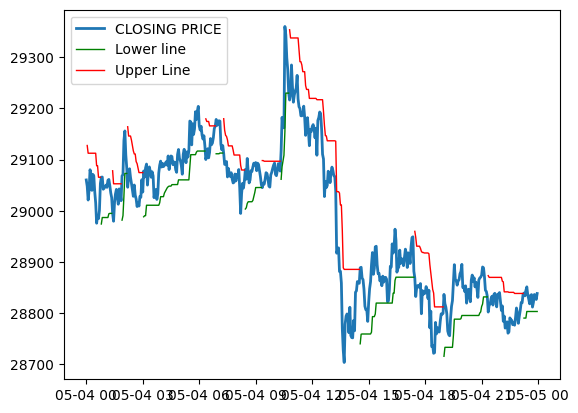

In [299]:
plt.plot(data2['Close'], linewidth = 2, label = 'CLOSING PRICE')
plt.plot(data2['upt'], color = 'green', linewidth = 1, label = 'Lower line')
plt.plot(data2['dt'], color = 'r', linewidth = 1, label = 'Upper Line')
plt.legend(loc = 'upper left')
plt.show()

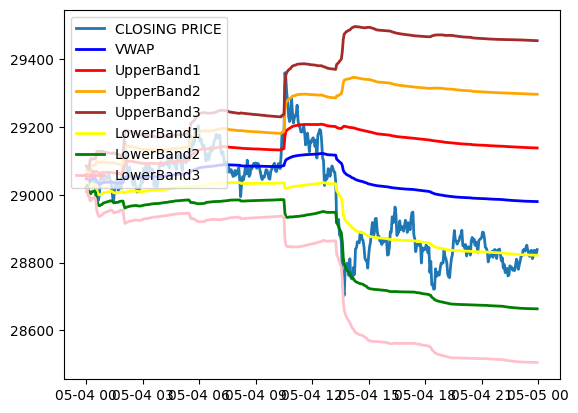

In [300]:
plt.plot(data2['Close'], linewidth = 2, label = 'CLOSING PRICE')
plt.plot(data2['VWAP'], color = 'blue', linewidth = 2, label = 'VWAP')
plt.plot(data2['UpperBand1'], color = 'red', linewidth = 2, label = 'UpperBand1')
plt.plot(data2['UpperBand2'], color = 'orange', linewidth = 2, label = 'UpperBand2')
plt.plot(data2['UpperBand3'], color = 'brown', linewidth = 2, label = 'UpperBand3')
plt.plot(data2['LowerBand1'], color = 'yellow', linewidth = 2, label = 'LowerBand1')
plt.plot(data2['LowerBand2'], color = 'green', linewidth = 2, label = 'LowerBand2')
plt.plot(data2['LowerBand3'], color = 'pink', linewidth = 2, label = 'LowerBand3')
plt.legend(loc = 'upper left')
plt.show()

## The Smart Money Concept Order Block Indicator
---

    1:15 oben -> 25
    1:27 unten -> 29
    4:33 oben -> 91
    5:09 unten -> 103
    6:00 oben -> 120
    6:57 oben -> 139
    8:09 oben -> 163
    8:15 unten -> 165
    10:09 unten -> 203
    11:12 oben -> 224
    12:06 oben -> 243
    13:06 oben -> 263
    14:06 unten -> 283
    16:03 unten -> 321
    17:00 unten -> 340
    17:18 oben -> 346
    18:06 oben -> 362
    18:39 oben -> 373
    19:15 unten -> 385
    19:42 unten -> 394
    20:00 oben -> 400
    21:06 oben -> 422
    21:42 oben -> 434
    23:45 unten -> 475

    13  28950.98
    29  28975.0 JA
    59  28991.35
    103  29057.82 JA
    131  29090.56 JA
    165  28982.58 JA
    174  29032.07
    191  29035.26
    273  28663.64
    321  28795.01
    370  28673.59
    427  28784.25
    445  28748.0

In [301]:
import pandas as pd
import numpy as np

def swings(data, length):
    upper = data['High'].rolling(window=length).max()
    lower = data['Low'].rolling(window=length).min()

    os = np.where(data['High'].shift(length) > upper, 0, np.where(data['Low'].shift(length) < lower, 1, np.nan))
    os = pd.Series(os).fillna(method='ffill')
    top = np.where((os == 0) & (os.shift() != 0), data['High'].shift(length), 0)
    btm = np.where((os == 1) & (os.shift() != 1), data['Low'].shift(length), 0)
    return [pd.Series(top).shift(-length), pd.Series(btm).shift(-length)]


def putValues(data, length, band):
    swings_data_btm = swings(data2, length)[1]
    swings_data_top = swings(data2, length)[0]

    swings_data_btm.index = data.index
    swings_data_top.index = data.index
    data["btmm"] = swings_data_btm
    data["btmm"].replace(0, np.nan, inplace=True)
    data["topp"] = swings_data_top
    data["topp"].replace(0, np.nan, inplace=True)
    if(band==0):
        return data["btmm"]
    else:
        return data["topp"]
print(putValues(data2, 5, 0).iloc[25:30])

Opent
2023-05-04 01:15:00        NaN
2023-05-04 01:18:00        NaN
2023-05-04 01:21:00        NaN
2023-05-04 01:24:00        NaN
2023-05-04 01:27:00    28975.0
Name: btmm, dtype: float64


In [302]:
data2["topp"].iloc[20:30]

Opent
2023-05-04 01:00:00        NaN
2023-05-04 01:03:00        NaN
2023-05-04 01:06:00        NaN
2023-05-04 01:09:00        NaN
2023-05-04 01:12:00        NaN
2023-05-04 01:15:00    29077.0
2023-05-04 01:18:00        NaN
2023-05-04 01:21:00        NaN
2023-05-04 01:24:00        NaN
2023-05-04 01:27:00        NaN
Name: topp, dtype: float64

## The Strategy
---

In [369]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

class PIES(Strategy):

    def init(self):
        self.orderblocksU = []
        self.orderblocksB = []
        self.tagged = False
        self.taggedcounter = 0
        self.candlecount = 1
        self.trade_opened = False
        self.stoploss = 0
        self.sholong = 0  #0 stands for long trade and 1 for short trade
        self.target = 0
        self.orderblocklow = 0
        self.supertrendu = self.I(get_supertrend, self.data.df, lookback=10, multiplier=2.5, band=0)
        self.supertrendl = self.I(get_supertrend, self.data.df, lookback=10, multiplier=2.5, band=1)
        self.vwap = self.I(VWAP2, self.data.df, 0)
        self.vwapu2 = self.I(VWAP2, self.data.df, 3)
        self.vwapl2 = self.I(VWAP2, self.data.df, 4)
        self.vwapu3 = self.I(VWAP2, self.data.df, 5)
        self.vwapl3 = self.I(VWAP2, self.data.df, 6)
        self.upperOB = self.I(putValues, self.data.df, length=5, band=1)
        self.lowerOB = self.I(putValues, self.data.df, length=5, band=0)

    def next(self):
        if(self.upperOB[-1] > 0):
            self.orderblocksU.append([self.data.High[-1], self.data.Low[-1], self.candlecount])
        if(self.lowerOB[-1] > 0):
            self.orderblocksB.append([self.data.High[-1], self.data.Low[-1], self.candlecount])
        if not self.trade_opened:
            if self.tagged==False:
                for high, low, candle in self.orderblocksU:
                    if self.data.High[-1] > low and self.data.High[-1] > self.vwapu2[-1] * 0.998:
                            self.tagged = True
                            self.orderblocklow = low
                            self.sholong = 1
                            self.orderblocksU = [(high, low, candle) for high, low, candle in self.orderblocksU if not (self.data.High[-1] > low and self.data.High[-1] > self.vwapu2[-1] * 0.998)]
                            break
                for high, low, candle in self.orderblocksB:
                    if self.data.Low[-1] < high and self.data.Low[-1] < self.vwapl2[-1] * 1.002:
                            self.tagged = True
                            self.orderblocklow = low
                            self.sholong = 1
                            self.orderblocksU = [(high, low, candle) for high, low, candle in self.orderblocksU if not (self.data.High[-1] > low and self.data.High[-1] > self.vwapu2[-1] * 0.998)]
                            break
            elif self.tagged == True and self.sholong == 1:
                if self.taggedcounter < 10:
                    if self.data.High[-1] < self.orderblocklow:
                        if ((self.data.High[-1] - self.data.Low[-1])*0.1 - self.data.High[-1]) < self.data.Open[-1]:
                            self.sell(size=0.1)
                            self.trade_opened = True
                    self.taggedcounter += 1
                else: 
                    self.tagged = False
                    self.taggedcounter = 0
            elif self.tagged == True and self.sholong == 0:
                if self.taggedcounter < 10:
                    if self.data.High[-1] < self.orderblocklow:
                        if ((self.data.High[-1] - self.data.Low[-1])*0.1 - self.data.High[-1]) < self.data.Open[-1]:
                            self.buy(size=0.1)
                            self.trade_opened = True
                else: 
                    self.tagged = False
                    self.taggedcounter = 0
                self.taggedcounter += 1
                
        else: # Stop loss path
            if self.trade_opened:
                if self.sholong == 0:
                    if(self.supertrendu[-1] > 0 and self.supertrendl > 0) or self.data.Low < self.stoploss:
                        self.position.close()
                        self.trade_opened = False
                else:
                    if(self.supertrendl[-1] > 0 and self.supertrendu > 0) or self.data.High > self.stoploss:
                        self.position.close()
                        self.trade_opened = False

        self.candlecount = self.candlecount + 1
        
bt = Backtest(data2, PIES, cash=100000, commission=0.002, exclusive_orders=True)
# Run the backtest and append the results to the list
output = bt.run()
bt.plot()

/Users/dennisschielke/Library/Python/3.9/lib/python/site-packages/backtesting/_plotting.py:250: BokehDeprecationWarning:

Passing lists of formats for DatetimeTickFormatter scales was deprecated in Bokeh 3.0. Configure a single string format for each scale

/Users/dennisschielke/Library/Python/3.9/lib/python/site-packages/backtesting/_plotting.py:250: UserWarning:

DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'

/Users/dennisschielke/Library/Python/3.9/lib/python/site-packages/backtesting/_plotting.py:250: BokehDeprecationWarning:

Passing lists of formats for DatetimeTickFormatter scales was deprecated in Bokeh 3.0. Configure a single string format for each scale

/Users/dennisschielke/Library/Python/3.9/lib/python/site-packages/backtesting/_plotting.py:250: UserWarning:

DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'



GridPlot(id='p26478', ...)